# Integrantes:
- Augusto Durães Camargo - 190084731
- Eduardo Rodrigues de Farias - 190086521
- João Vitor Ferreira Alves - 160127912

# Resolução: classificação de mudas de plantas

Para a resolução do problema foi utilizado a arquitetura de rede neural ResNet50v2, note que a rede utilizada não tinha nenhum parâmetro treinado, utilizamos apenas a arquitetura pré definida. Além deste notebook será disponibilizado no repositório um script que faz data augmentation do dataset v1 do kaggle. O dataset também está disponibilizado no zip, no entanto não está no repositório dada as limitações de tamanho de arquivos/diretório impostas pelo github.

link do repositório: https://github.com/augustocrmg/t1-topicos-deep-learning (solicitar o a acesso).

In [22]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!unzip drive/MyDrive/dataset_balanceado.zip

Archive:  drive/MyDrive/dataset_balanceado.zip
replace dataset_balanceado/Shepherd’s Purse/aug_632.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [39]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.utils import image_dataset_from_directory
from keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [40]:
image_size = (224, 224)
batch_size = 8

train_ds, val_ds = image_dataset_from_directory(
    "dataset_balanceado",
    validation_split=0.3,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
)

classes = train_ds.class_names

Found 9600 files belonging to 12 classes.
Using 6720 files for training.
Using 2880 files for validation.


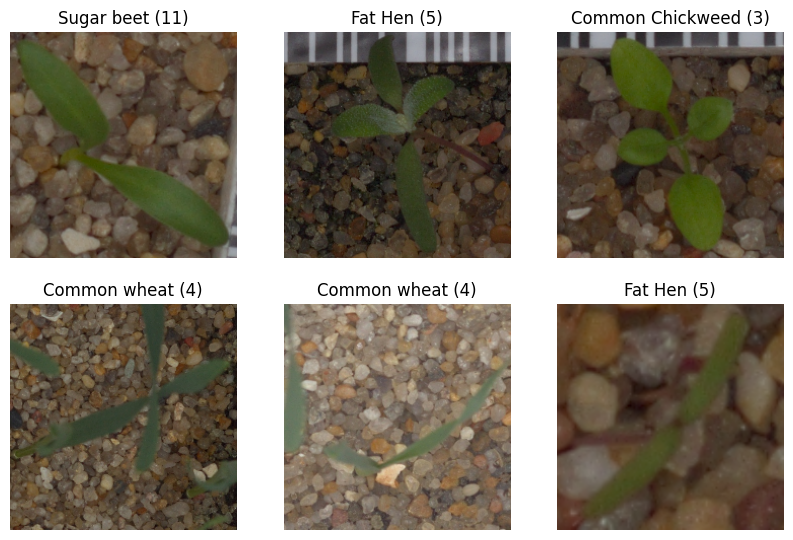

In [41]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):
        image = images[i].numpy().astype("uint8")
        label = np.argmax(labels[i])

        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(f"{classes[label]} ({label})")
        plt.axis("off")

In [42]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [45]:
model = ResNet50V2(
    include_top=True,
    weights=None,
    classes=len(classes),
)

In [46]:
model.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 23,589,388 (89.99 MB)

 Trainable params: 23,543,948 (89.81 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [47]:
model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [48]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[
        ModelCheckpoint("model.keras", save_best_only=True),
        EarlyStopping(patience=10)
    ],
    epochs=100,
)

Epoch 1/100
840/840 ━━━━━━━━━━━━━━━━━━━━ 82s 45ms/step - accuracy: 0.3164 - loss: 1.9788 - val_accuracy: 0.5045 - val_loss: 1.4588
Epoch 2/100
840/840 ━━━━━━━━━━━━━━━━━━━━ 33s 39ms/step - accuracy: 0.6101 - loss: 1.1031 - val_accuracy: 0.5104 - val_loss: 1.6014
Epoch 3/100
840/840 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - accuracy: 0.7200 - loss: 0.8081 - val_accuracy: 0.6767 - val_loss: 0.9684
Epoch 4/100
840/840 ━━━━━━━━━━━━━━━━━━━━ 33s 39ms/step - accuracy: 0.7722 - loss: 0.6410 - val_accuracy: 0.6326 - val_loss: 1.3837
Epoch 5/100
840/840 ━━━━━━━━━━━━━━━━━━━━ 33s 39ms/step - accuracy: 0.8167 - loss: 0.4990 - val_accuracy: 0.6615 - val_loss: 1.1535
Epoch 6/100
840/840 ━━━━━━━━━━━━━━━━━━━━ 35s 41ms/step - accuracy: 0.8488 - loss: 0.4386 - val_accuracy: 0.7878 - val_loss: 0.6577
Epoch 7/100
840/840 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - accuracy: 0.8727 - loss: 0.3614 - val_accuracy: 0.7965 - val_loss: 0.6381
Epoch 8/100
840/840 ━━━━━━━━━━━━━━━━━━━━ 35s 42ms/step - accuracy: 0.8958 - loss: 0

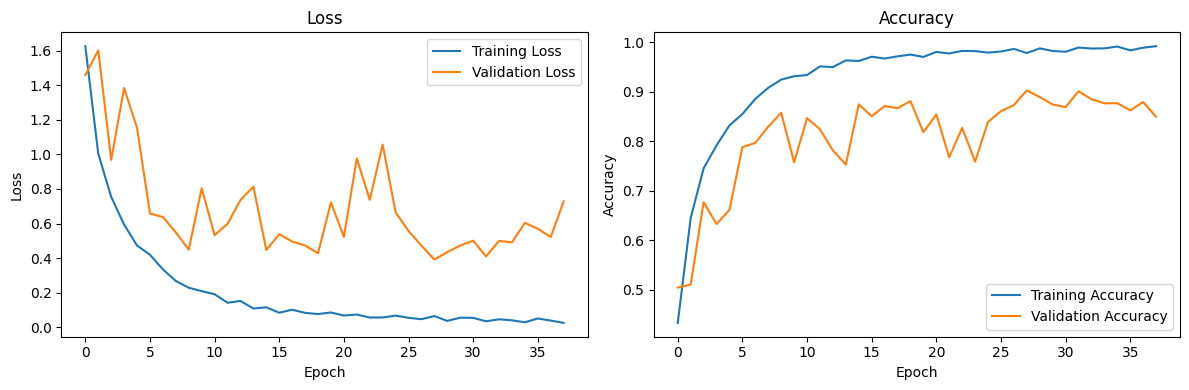

In [49]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)

if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
else:
    plt.plot(history.history['acc'], label='Training Accuracy')
    plt.plot(history.history['val_acc'], label='Validation Accuracy')

plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [50]:
!cp model.keras drive/MyDrive/model.keras

In [54]:
model = load_model("model_res.keras")

In [55]:
score, acc = model.evaluate(val_ds,
                                batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

360/360 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9237 - loss: 0.2851
Test score: 0.2851598262786865
Test accuracy: 0.9166666865348816


360/360 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step


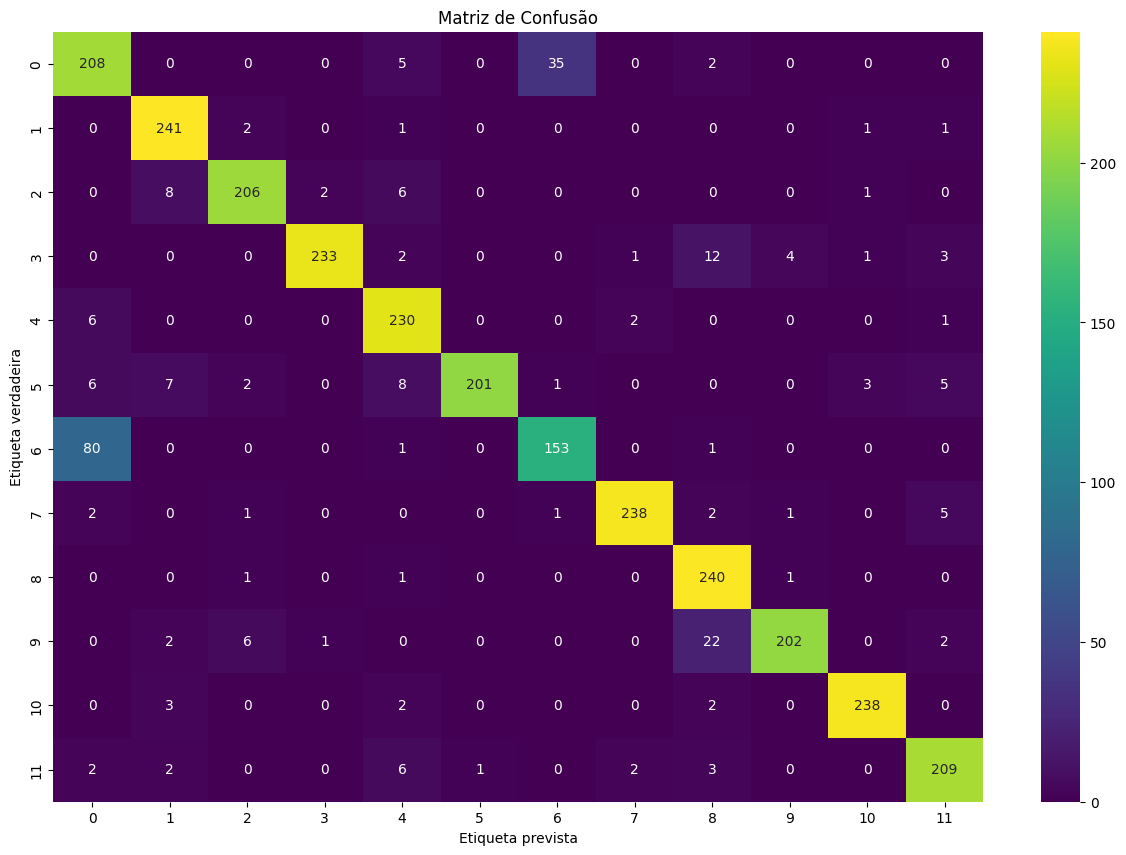

In [52]:
predictions = model.predict(val_ds)
predictions = np.argmax(predictions, axis=1)

# Gera a matriz de confusão
y_test = np.concatenate([y for x, y in val_ds], axis=0)
confusion_mtx = confusion_matrix(np.argmax(y_test, axis=1), predictions)

# Plota a matriz de confusão
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(confusion_mtx, annot=True, fmt="d", ax=ax, cmap="viridis")
ax.set_xlabel("Etiqueta prevista")
ax.set_ylabel("Etiqueta verdadeira")
ax.set_title("Matriz de Confusão");